In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

prioritized_path = DATA_PROCESSED / "prioritized_routes.csv"
route_delay_path = DATA_PROCESSED / "route_delay_kpis.csv"

routes = pd.read_csv(prioritized_path)
route_delay = pd.read_csv(route_delay_path)

routes.head(), route_delay.head()


(    route_id route_short_name_sched      route_long_name_sched  route_type  \
 0  19118_700                    468  PlusBus Nationalparklinie         700   
 1  17452_900                     M4                        NaN         900   
 2  17520_700                     U6                        NaN         700   
 3  17514_400                     U2                        NaN         400   
 4  17609_700                     M4                        NaN         700   
 
    n_trips  route_short_name_delay      route_long_name_delay  n_events  \
 0       56                   468.0  PlusBus Nationalparklinie       4.0   
 1     3112                     NaN                        NaN       0.0   
 2     3070                     NaN                        NaN       0.0   
 3     2893                     NaN                        NaN       0.0   
 4     2518                     NaN                        NaN       0.0   
 
    avg_delay_min  share_over_5min  share_on_time_or_early  impact

In [2]:
# We approximate total delay minutes per route as:
# total_delay_min = max(avg_delay_min, 0) * n_events

route_delay["baseline_total_delay_min"] = (
    route_delay["avg_delay_min"].clip(lower=0) * route_delay["n_events"]
)

baseline_total = route_delay["baseline_total_delay_min"].sum()

baseline_total


np.float64(4.0)

In [3]:
TOP_N = 10
IMPROVEMENT_FACTOR = 0.5  # 50% reduction in average delay

top_n_routes = routes.sort_values("priority_score", ascending=False).head(TOP_N)
top_ids = set(top_n_routes["route_id"].tolist())

scenario = route_delay.copy()

scenario["is_improved"] = scenario["route_id"].isin(top_ids)

scenario["scenario_avg_delay_min"] = scenario.apply(
    lambda row: row["avg_delay_min"] * (1 - IMPROVEMENT_FACTOR)
    if row["is_improved"] and row["avg_delay_min"] > 0
    else row["avg_delay_min"],
    axis=1,
)

scenario["scenario_total_delay_min"] = (
    scenario["scenario_avg_delay_min"].clip(lower=0) * scenario["n_events"]
)

scenario_total = scenario["scenario_total_delay_min"].sum()

baseline_total, scenario_total, baseline_total - scenario_total


(np.float64(4.0), np.float64(2.0), np.float64(2.0))

In [4]:
reduction_abs = baseline_total - scenario_total
reduction_pct = reduction_abs / baseline_total if baseline_total > 0 else 0

summary = pd.DataFrame(
    {
        "metric": [
            "baseline_total_delay_min",
            "scenario_total_delay_min",
            "reduction_delay_min",
            "reduction_pct",
        ],
        "value": [
            baseline_total,
            scenario_total,
            reduction_abs,
            reduction_pct,
        ],
    }
)

summary


,metric,value
0,baseline_total_delay_min,4.0
1,scenario_total_delay_min,2.0
2,reduction_delay_min,2.0
3,reduction_pct,0.5


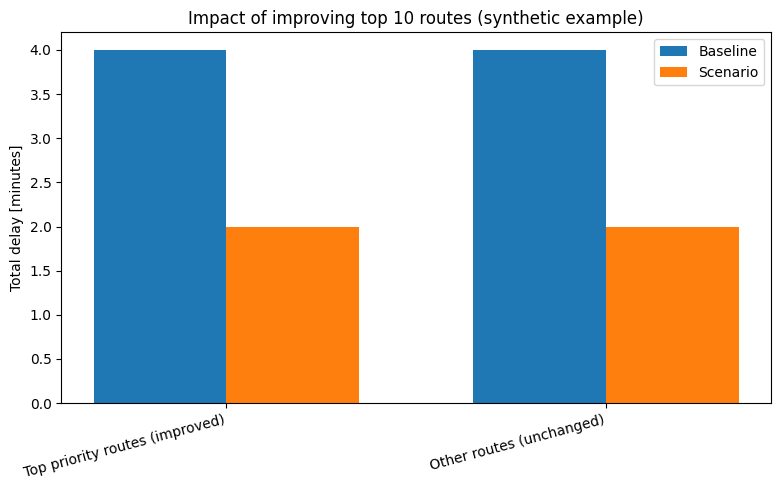

In [5]:
scenario["baseline_total_delay_min"] = route_delay["baseline_total_delay_min"]

agg = scenario.groupby("is_improved")[["baseline_total_delay_min", "scenario_total_delay_min"]].sum().reset_index()

labels = ["Top priority routes (improved)", "Other routes (unchanged)"]
baseline_vals = agg["baseline_total_delay_min"].tolist()
scenario_vals = agg["scenario_total_delay_min"].tolist()

x = range(2)

plt.figure(figsize=(8, 5))
width = 0.35

plt.bar([i - width/2 for i in x], baseline_vals, width, label="Baseline")
plt.bar([i + width/2 for i in x], scenario_vals, width, label="Scenario")

plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("Total delay [minutes]")
plt.title(f"Impact of improving top {TOP_N} routes (synthetic example)")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
scenario_routes_path = DATA_PROCESSED / "scenario_routes_delay.csv"
scenario_summary_path = DATA_PROCESSED / "scenario_summary.csv"

scenario.to_csv(scenario_routes_path, index=False)
summary.to_csv(scenario_summary_path, index=False)

scenario_routes_path, scenario_summary_path


(WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/scenario_routes_delay.csv'),
 WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/scenario_summary.csv'))